# Stellar Interpretation for Meteoritic data and PLotting (for Everyone) - SIMPLE 

In [87]:
import sys

import os
import re
import numpy as np
import matplotlib.pyplot as plt
#import data_dirlib.patches as patch
import time as t
import more_itertools as mit

import h5py
import csv

import datetime
#from datetime import datetime
import ast

# check if the abundance file is there. If it is not available, we load the models and we need more packages.
# or I just remove it and I go ahead with the typical mode
# if check_file is true, there is no need to load all the models again

!rm selected_abundances_data.txt
check_data_file = os.path.isfile('selected_abundances_data.txt')

#if check_data_file == False:
#    sys.path.append('/home/marco/work/NuGridPy')
#    from nugridpy import utils as u
#    from nugridpy import nugridse as mp
from nugridpy import utils as u
from nugridpy import nugridse as mp

#%matplotlib nbagg
%pylab ipympl


# data stored
#data_dir="/data/nugrid/data/chetec-infra_models/"
data_dir="/data/nugrid_data/chetec-infra_models/"

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [88]:
# function to load Sieverding+2018
def get_profiles(fname,isotopes=["mg24"],presn=True,decayed=False):
    """ extracts mass fraction profiles from hdf5 data file. 
       keywork argument isotopes=["al26"] specifies which isotopes to return.
       Return value is a dictionary containing a "pre-sn" and post-sn" key and the mass fractions for each isotope as well as the mass coordinates.
    """
# Open HDF5 file
    data_file=h5py.File(fname)
    results=dict()
    #initialize output dicts
    results["pre-sn"]=dict()
    results["post-sn"]=dict()
    
    types=["post-sn"]
    if presn:
        types.append("pre-sn")
    for typ in types:
       data=data_file[typ]
       mr=data["mass_coordinates_sun"]
       results[typ]["mr"]=mr
       # need to decode binary isotope names to get strings
       isos=[ name.decode() for name in data["isotopes"] ]
       #find index jiso for isotope and get zonal mass fractions
       for iso in isotopes:
           jiso=isos.index(iso)
           if decayed and typ=="post-sn":
              results[typ][iso]=data["mass_fractions_decayed"][:,jiso]
           else:
              results[typ][iso]=data["mass_fractions"][:,jiso]
    return(results)


In [89]:
# function to calculate all ratios and slopes from abundance profiles 
def give_ratios(abu, iso_up, iso_down, ref_mu_and_epsilon, ref_slope):
    """ function: returns delta*1000, epsilon*1e4 (or mu*1e6), with and without mass correction, and slopes
    Inputs are: abu: stellar abundances
    iso_abu: isotopes names consistent with stellar abundance arrays
    abu_solar: solar abundances
    iso_solar: isotopes names consistent with the solar abundance array
    iso_up: isotopes I want to calculate the delta for
    iso_down: normalization isotope for delta
    ref_mu_and_epsilon: reference isotope used to normalize to get epsilon and mu
    ref_slope: reference isotope used to normalize epsilon*1e4 (ds or dsm) to get the slopes"""
    
    rho = [abu[e_label.index(iso_up[i])]/\
                  abu[e_label.index(iso_down[i])]/\
                  (s_abu[s_iso_new.index(iso_up[i].replace("*", ""))]/\
                   s_abu[s_iso_new.index(iso_down[i].replace("*", ""))])-1.\
                  for i in range(len(iso_up))]
    ind_ = iso_up.index(ref_mu_and_epsilon)
    # ds_maria = ds without applying mass correction (factor)
    ds_maria = np.array(rho) / np.array(rho[ind_])
    # mass correction factor, derived using natural logs of atomic masses
    factor = [np.log(iso_masses[name_iso_masses.index(iso_up[i].replace("*", ""))]/\
                   iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))]) /\
         np.log(iso_masses[name_iso_masses.index(ref_mu_and_epsilon)]/\
                   iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])\
         for i in range(len(iso_up))] ; factor = np.array(factor)
    # ds is epsilon (/10000) or mu (/1e6), based on kinetic fractionation law - Steele+ 2012
    # Steele+ 2012 only applied for 1 element. Generalize?
    # or, do we need to generalize here, if we plot e,g., mu(Ni) vs mu(Fe)
    ds = [np.array(ds_maria[i]) - factor[i] for i in range(len(iso_up))]
    # and now the slopes... 
    ind_ = iso_up_plot.index(ref_slope)
    # do we need to generalize here, and allow for ds_element1 and ds_element2...
    # corr_factor_mix = ...
    slope = np.array(ds) / np.array(ds[ind_]) # * corr_factor_mix
    # done
    return(rho, slope)


In [90]:
def func_el_corr(whatever, abu, ref_up, ref_down, mode=0,file_fractionation=None,what_in_file=None):
    """Documentation: 
    # mode = 0: c= (ref_EL1_el2/ref_el1_EL2)_sun/(ref_EL1_el2/ref_el1_EL2)_sun = 1. Same without correction factor;
    # mode = 1: c= (ref_EL1_el2/ref_el1_EL2)_star*/(ref_EL1_el2/ref_el1_EL2)_sun
    # mode = 2: c= (ref_EL1_el2/ref_el1_EL2)_file/(ref_EL1_el2/ref_el1_EL2)_sun
    # function will return whatever * correction factor

    whatever:           whatever is read, delta, epsilon, mu, slope...
    abu:                abundances from the models used to calculate the whatever loaded
    ref_up:             ref element 1 in normalization
    ref_down:           ref element 2 in normalization
    mode:               see above
    file_fractionation: file from wich it is read the element fractionation in the sample
    what_in_file:       specify what correction is needed, given the case of interest """
    
    if mode == 0:
        
        whatever_corrected = whatever
    
    elif mode == 1:
        
        c = abu[e_label.index(ref_up)]/abu[e_label.index(ref_down)]/\
             (s_abu[s_iso_new.index(ref_up.replace("*", ""))]/\
              s_abu[s_iso_new.index(ref_down.replace("*", ""))])
        whatever_corrected = whatever * np.array(c)
    
    elif mode == 2:
        
        # open file and read the fractionation you want from what_in_file
        f_ = open(file_fractionation, 'r')
        header = f_.readline()
        if header.split()[0] != ref_up.rpartition('-')[0]:
            print('Element 1 in '+file_fractionation+' does not match '+ref_up+'! Stop!')
        if header.split()[1] != ref_down.rpartition('-')[0]:
            print('Element 2 in '+file_fractionation+' does not match '+ref_down+'! Stop!')
        for i in f_.readlines():
            if i.split()[0] == what_in_file:
                c = float(i.split()[1])
                break
        f_.close() # done with the file
        c = c/(s_abu[s_iso_new.index(ref_up.replace("*", ""))]/s_abu[s_iso_new.index(ref_down.replace("*", ""))])
        whatever_corrected = whatever * np.array(c)
    
    return(whatever_corrected)


In [91]:
def func_species_deck(string_set,abundance,iso_list_spec,iso_list_master):
    """Documentation: 
    # function will return isotope abundance if present in the list, or zero to be added

    string_set:         identifier of the origin set
    abundance:          abundances to be found
    iso_list_spec:      list of isotopes present in the specific model
    iso_list_master:    this should be iso_list, defined by the user """
    dum = []
    for i in iso_list_master:
        try:
            dum.append(abundance[iso_list_spec.index(i)])
        except ValueError:
            dum.append(0.)
            print(string_set,', missing isotope set to zero: ',i)
    
    return(dum)

In [92]:
# check if the abundance file is there. If it is not available, we load the models.
# or I just remove it and I go ahead with the typical mode

#!rm selected_abundances_data.txt
check_data_file = os.path.isfile('selected_abundances_data.txt')

# if check_file is true, there is no need to load all the models again

In [93]:
if check_data_file == False:
    # loading Ritter+18 model
    fol2mod = data_dir+'R18/'
    # load instances of models
    # 15Msun
    pt_15 = mp.se(fol2mod,'M15.0Z2.0e-02.Ma.0020601.out.h5',rewrite=True)
    cyc_15 = pt_15.se.cycles[-1]
    #pt_15.se.get('temperature')
    t9_cyc_15  = pt_15.se.get(cyc_15,'temperature')
    mass_15 = pt_15.se.get(cyc_15,'mass')
    # 20Msun
    pt_20 = mp.se(fol2mod,'M20.0Z2.0e-02.Ma.0021101.out.h5',rewrite=True)
    cyc_20 = pt_20.se.cycles[-1]
    #pt_20.se.get('temperature')
    t9_cyc_20  = pt_20.se.get(cyc_20,'temperature')
    mass_20 = pt_20.se.get(cyc_20,'mass')
    # 25Msun
    pt_25 = mp.se(fol2mod,'M25.0Z2.0e-02.Ma.0023601.out.h5',rewrite=True)
    cyc_25 = pt_25.se.cycles[-1]
    #pt_25.se.get('temperature')
    t9_cyc_25  = pt_25.se.get(cyc_25,'temperature')
    mass_25 = pt_25.se.get(cyc_25,'mass')
    
    # loading AGB models
    # test case, M=3Msun, Z=0.03, Battino et al.
    pt_3 = mp.se(data_dir+'agb_surf_m3z2m3/','surf.h5',rewrite=True)


Searching files, please wait.......
Writing preprocessor files
M15.0Z2.0e-02.Ma.0020601.out.h5
 reading ['temperature']...100%

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/R18/h5Preproc.txt'



 reading ['mass']...100%Searching files, please wait.......
Writing preprocessor files
M20.0Z2.0e-02.Ma.0021101.out.h5
 reading ['temperature']...100%

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/R18/h5Preproc.txt'



 reading ['mass']...100%Searching files, please wait.......
Writing preprocessor files
M25.0Z2.0e-02.Ma.0023601.out.h5
 reading ['temperature']...100%

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/R18/h5Preproc.txt'



 reading ['mass']...100%Searching files, please wait.......
Writing preprocessor files
M3.00Z.0300.0011101.surf.h5
M3.00Z.0300.0023101.surf.h5
M3.00Z.0300.0066101.surf.h5
M3.00Z.0300.0069101.surf.h5
M3.00Z.0300.0024101.surf.h5
M3.00Z.0300.0039101.surf.h5
M3.00Z.0300.0000101.surf.h5
M3.00Z.0300.0022101.surf.h5
M3.00Z.0300.0031101.surf.h5
M3.00Z.0300.0025101.surf.h5
M3.00Z.0300.0015101.surf.h5
M3.00Z.0300.0038101.surf.h5
M3.00Z.0300.0036101.surf.h5
M3.00Z.0300.0086101.surf.h5
M3.00Z.0300.0004101.surf.h5
M3.00Z.0300.0028101.surf.h5
M3.00Z.0300.0061101.surf.h5
M3.00Z.0300.0013101.surf.h5
M3.00Z.0300.0027101.surf.h5
M3.00Z.0300.0029101.surf.h5
M3.00Z.0300.0041101.surf.h5
M3.00Z.0300.0072101.surf.h5
M3.00Z.0300.0071101.surf.h5
M3.00Z.0300.0001101.surf.h5
M3.00Z.0300.0033101.surf.h5
M3.00Z.0300.0083101.surf.h5
M3.00Z.0300.0005101.surf.h5
M3.00Z.0300.0040101.surf.h5
M3.00Z.0300.0092101.surf.h5
M3.00Z.0300.0074101.surf.h5
M3.00Z.0300.0094101.surf.h5
M3.00Z.0300.0020101.surf.h5
M3.00Z.0300.00591

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/agb_surf_m3z2m3/h5Preproc.txt'



In [94]:
#ccc = pt_3.se.cycles[-1]
#print(ccc, pt_3.se.get(ccc,'iso_massf','C-12'))

In [95]:
if check_data_file == False:
    # loading Pignatari+16 model
    fol2mod = data_dir+'P16/'
    # load instances of models
    # 15Msun
    P16_15 = mp.se(fol2mod,'M15.0',rewrite=True)
    cyc_P16_15 = P16_15.se.cycles[-1]
    #pt_15.se.get('temperature')
    t9_cyc_P16_15  = P16_15.se.get(cyc_P16_15,'temperature')
    mass_P16_15 = P16_15.se.get(cyc_P16_15,'mass')
    # 20Msun
    P16_20 = mp.se(fol2mod,'M20.0',rewrite=True)
    cyc_P16_20 = P16_20.se.cycles[-1]
    #pt_20.se.get('temperature')
    t9_cyc_P16_20  = P16_20.se.get(cyc_P16_20,'temperature')
    mass_P16_20 = P16_20.se.get(cyc_P16_20,'mass')
    # 25Msun
    P16_25 = mp.se(fol2mod,'M25.0',rewrite=True)
    cyc_P16_25 = P16_25.se.cycles[-1]
    #pt_25.se.get('temperature')
    t9_cyc_P16_25  = P16_25.se.get(cyc_P16_25,'temperature')
    mass_P16_25 = P16_25.se.get(cyc_P16_25,'mass')

Searching files, please wait.......
Writing preprocessor files
M15.0Z2.0e-02.standard.0129401.restart.h5
M15.0Z2.0e-02.standard.0129501.restart.h5
M15.0Z2.0e-02.standard.0129301.restart.h5
 reading ['mass']...100%Searching files, please wait.......


Exception in thread Thread-108:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/P16/h5Preproc.txt'



Writing preprocessor files
M20.0Z2.0e-02.standard.0132601.restart.h5
M20.0Z2.0e-02.standard.0132701.restart.h5
M20.0Z2.0e-02.standard.0132501.restart.h5
 reading ['mass']...100%Searching files, please wait.......


Exception in thread Thread-112:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/P16/h5Preproc.txt'



Writing preprocessor files
M25.0Z2.0e-02.standard.0097101.restart.h5
M25.0Z2.0e-02.standard.0096801.restart.h5
M25.0Z2.0e-02.standard.0096901.restart.h5
M25.0Z2.0e-02.standard.0097001.restart.h5
 reading ['mass']...100%...100%

Exception in thread Thread-116:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/P16/h5Preproc.txt'



In [96]:
#!Evelyn new initialization to make Lawson et al. faster
global start_time

z_names = ['Neut', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 
           'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 
           'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 
           'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
           'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 
           'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 
           'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U']

def print_time(message):
    print(f"{message} - {(t.time()-start_time):.2f} s")
    

def get_el_from_z(z):
    '''
    Very simple Vfunction that gives the atomic number AS A STRING when given the element symbol.
    Uses predefined a dictionnary.
    Parameter :
    z : string or number
    For the other way, see get_z_from_el
    '''
    z = int(z)
    
    return (z_names[z])    


In [97]:
# function to read Lawson data
def load_lawson22(file_name, num_species):    
    print(file_name)
    #mass_lines = %sx findstr "mass enclosed" {filename}
    # getting mass enclosed and num particle
    mass_lines = !grep 'mass enclosed' {file_name}
    mass = [float(row.split()[3]) for row in mass_lines]
    numpart = [int(row.split()[0][1:]) for row in mass_lines]
    print_time('num and mass')
    number_of_parts = len(numpart) # number of particles (it may change from model to model)
    print('# particles = ',number_of_parts)

    # open and read abundances for all trajectories
    a,x,z,iso = [],[],[],[]
    with open(file_name, "rt") as f:
        i = 0
        while i < number_of_parts:
            f.readline(); f.readline();
            j = 0
            a_i,x_i,z_i,iso_i = [],[],[],[]
            while j < num_species:
                line = f.readline().split()
                a_i.append(int(line[0]))
                z_i.append(int(line[1]))
                x_i.append(float(line[2]))
                iso_i.append(f"{get_el_from_z(line[1])}-{line[0]}")
                j += 1
            a.append(a_i); z.append(z_i); x.append(x_i); iso.append(iso_i)
            i += 1        

    return (mass, numpart, number_of_parts, a, z, x, iso)


In [98]:
if check_data_file == False:
    # Loading Lawson+22 - 1 peformance upgrade
    dir_law = data_dir+'LAW22/'
    models_list = ['M15s_run15f1_216M1.3bgl_mp.txt','M20s_run20f1_300M1.56jl_mp.txt','M25s_run25f1_280M1.83rrl_mp.txt']
    num_species = 5209
    
    start_time = t.time()
    numpart_all = []; massinc_all = []
    anum_all = []; znum_all = []; x_all = []
    iso_name_all = []; num_of_part_all = []
    for i in models_list:
        mass, numpart, number_of_parts, a, z, x, iso = load_lawson22(dir_law+i,num_species)
        massinc_all.append(mass); num_of_part_all.append(number_of_parts); numpart_all.append(numpart) 
        anum_all.append(a); znum_all.append(z); x_all.append(x); iso_name_all.append(iso)
    
    print_time("done with Lawson")

/data/nugrid/data/chetec-infra_models/LAW22/M15s_run15f1_216M1.3bgl_mp.txt
num and mass - 0.11 s
# particles =  949
/data/nugrid/data/chetec-infra_models/LAW22/M20s_run20f1_300M1.56jl_mp.txt
num and mass - 9.87 s
# particles =  1298
/data/nugrid/data/chetec-infra_models/LAW22/M25s_run25f1_280M1.83rrl_mp.txt
num and mass - 24.03 s
# particles =  1385
done with Lawson - 38.93 s


In [99]:
if check_data_file == False:
    # dir where Sieverdin models are located
    dir_sie = data_dir+'SIE18/'
    
    file_sie_all = ["s15_data.hdf5","s20_data.hdf5","s25_data.hdf5"]

In [100]:
if check_data_file == False:
    # Rauscher - 1 peformance upgrade
    dir_rau = data_dir+'R02/'
    
    #models_rau = ['s15a28c.expl_yield']
    models_rau = ['s15a28c.expl_yield','s20a28n.expl_yield','s25a28d.expl_yield']
    
    start_time = t.time()
    
    rau_mass = []; rau_isos = []; rau_x = []
    for i in range(len(models_rau)):
        filename = dir_rau+models_rau[i]
        print(filename)
        f = open(filename,'r')
        head = f.readline(); isos_dum = head.split()[5:] # getting isotopes, not first header names
        #print_time('getting isotopes, not first header names')
        dum_a = [re.findall('\d+', ik)[0] for ik in isos_dum] # getting the A from isotope name
        #print_time('getting the A from isotope name')
        dum_el = [re.sub(r'[0-9]+', '', ik) for ik in isos_dum] # getting the element name from the isotope name
        #print_time('getting the element name from the isotope name')
        dum_new_iso = [dum_el[ik].capitalize()+'-'+dum_a[ik] for ik in range(len(isos_dum))]
        #print_time('more iso name stuff')
        rau_isos.append(dum_new_iso) # isotope name that we can use around, just neutron name is different, but not care
        #print_time('')
        #
        data = f.readlines()[:-2]                        # getting the all data, excepting the last two lines
                                              # done reading, just closing the file now
        #
        dum = [float(ii.split()[1])/1.989e+33 for ii in data]; rau_mass.append(dum) # converting in Msun too.
        #print_time('converting in Msun too.')
        x_dum = []
        
        
        data = [row.split()[3:] for row in data]
        #
        x_dum = np.transpose(data); x_dum = np.asfarray(x_dum,float)
        print_time("x transpose and done")
        rau_x.append(x_dum)


/data/nugrid/data/chetec-infra_models/R02/s15a28c.expl_yield
x transpose and done - 1.06 s
/data/nugrid/data/chetec-infra_models/R02/s20a28n.expl_yield
x transpose and done - 1.80 s
/data/nugrid/data/chetec-infra_models/R02/s25a28d.expl_yield
x transpose and done - 2.72 s


In [101]:
# abundances in mass fraction of all the isotopes in the network. 
# unstable nuclei are allowed to decay only within the first 2.5e4 s
# mmmzvvv.dif_iso_nod  received Jan 2023
# 013a000.dif_iso_nod  020a000.dif_iso_nod
# 015a000.dif_iso_nod  025a000.dif_iso_nod

if check_data_file == False:
    # data from LC18
    dir_lc18 = data_dir+'LC18/'

    models_lc18 = ['015a000.dif_iso_nod','020a000.dif_iso_nod','025a000.dif_iso_nod']
    
    skip_heavy_ = 43 # usedd to skip final ye and spooky abundances (see below)
    
    start_time = t.time()
    
    lc18_mass = []; lc18_isos = []; lc18_x = []
    for i in range(len(models_lc18)):
        filename = dir_lc18+models_lc18[i]
        print(filename)
        f = open(filename,'r')
        # getting isotopes, not first header names, and final ye and spooky abundances (group of isolated isotopes, 
        # probably sorted with artificial reactions handling mass conservation or sink particles approach)
        head = f.readline(); isos_dum = head.split()[4:-skip_heavy_] 
        # correcting names to get H1 (and the crazy P and A)
        isos_dum[0]=isos_dum[0]+'1'; isos_dum[1]=isos_dum[1]+'1'; isos_dum[6]=isos_dum[6]+'1' 
        #print_time('getting isotopes, not first header names')
        dum_a = [re.findall('\d+', ik)[0] for ik in isos_dum] # getting the A from isotope name
        #print_time('getting the A from isotope name')
        dum_el = [re.sub(r'[0-9]+', '', ik) for ik in isos_dum] # getting the element name from the isotope name
        #print_time('getting the element name from the isotope name')
        dum_new_iso = [dum_el[ik].capitalize()+'-'+dum_a[ik] for ik in range(len(isos_dum))]
        #print_time('more iso name stuff')
        lc18_isos.append(dum_new_iso) # isotope name that we can use around, just neutron name is different, but not care
        #print_time('')
        #
        data = f.readlines()[:-1]             # getting the all data, excepting the last fake line (bounch of zeros)
                                              # done reading, just closing the file now
        #
        dum = [float(ii.split()[0]) for ii in data]; lc18_mass.append(dum) # converting in Msun too.
        #print_time('converting in Msun too.')
        x_dum = []
        
        
        data = [row.split()[4:-skip_heavy_] for row in data]
        #
        x_dum = np.transpose(data); x_dum = np.asfarray(x_dum,float)
        print_time("x transpose and done")
        lc18_x.append(x_dum)

#print(len(lc18_isos[0]),len(lc18_x[0]))
#print([lc18_mass[i][-1] for i in [0,1,2]])

/data/nugrid/data/chetec-infra_models/LC18/015a000.dif_iso_nod
x transpose and done - 0.08 s
/data/nugrid/data/chetec-infra_models/LC18/020a000.dif_iso_nod
x transpose and done - 0.11 s
/data/nugrid/data/chetec-infra_models/LC18/025a000.dif_iso_nod
x transpose and done - 0.13 s


In [102]:
# load solar data
f=open('iniab1.4E-02As09.ppn','r')
solar_data = f.readlines()
f.close()

s_iso = []; z_iso = []; s_abu = []
for i in solar_data:
    s_iso.append(i[3:9].strip())
    z_iso.append(int(i[0:3]))
    s_abu.append(float(i[10:]))
s_iso = np.array(s_iso); s_abu = np.array(s_abu) 
a_iso = [i[2:].strip() for i in s_iso]; a_iso[0] = '1'; a_iso = [int(i) for i in a_iso]
s_iso[0] = 'h   1' # correction for H1 special name
# here below some simple way to build the isotope name with the same structure of the models.
s_iso_new = [i[:2].strip().capitalize()+'-'+i[2:].strip() for i in s_iso]



# load isotopic masses from isopy file (csv), based on Wang et al. 2017
with open('isotope_mass_W17.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)
    next(reader); next(reader)
    dum = []
    for row in reader:
        dum.append(row)
iso_dum = dum[0]; iso_masses = np.array([float(i) for i in dum[1]])

# here below some simple way to build the isotope name with the same structure of the models.
name_iso_masses = [re.sub(r'[0-9]+', '', i)+'-'+re.findall(r'\d+', i)[0] for i in iso_dum]

In [103]:
# alright. The previous cells just need to be run once. Once you got instances for all the models,
# you are good to go with the analysis. 
# what of the three models I want for each flavour?
# this is the deck for the models

if check_data_file == False:
    # ritter+ 18
    pt_exp = pt_20
    cyc_exp = cyc_20
    t9_cyc  = t9_cyc_20
    mass = mass_20
    
    # Pignatari+ 16
    p16_exp = P16_20
    p16_cyc = cyc_P16_20
    p16_t9_cyc  = t9_cyc_P16_20
    p16_mass = mass_P16_20
    
    # lawson+22 # 0=15Msun; 1=20Msun; 2=25Msun
    ind_ = 1
    numpart = numpart_all[ind_]; mass_inc = massinc_all[ind_]
    anum = anum_all[ind_]; znum = znum_all[ind_]; x = x_all[ind_]
    iso_name = iso_name_all[ind_]; num_of_part = num_of_part_all[ind_]
    
    # sieverdin et al # 0=15Msun; 1=20Msun; 2=25Msun
    ind_ = 1
    file_sie = file_sie_all[ind_]
    
    # Rauscher+02 # 0=15Msun; 1=20Msun; 2=25Msun
    ind_ = 1
    rau_mass_1 = rau_mass[ind_]; rau_x_1 = rau_x[ind_]
    rau_isos_1 = rau_isos[ind_]
    
    # Limongi & Chieffi 2018 # 0=15Msun; 1=20Msun; 2=25Msun
    ind_ = 1
    lc18_mass_1 = lc18_mass[ind_]; lc18_x_1 = lc18_x[ind_]
    lc18_isos_1 = lc18_isos[ind_]



In [104]:
if check_data_file == False:
    # Battino et al. -test case AGB
    sparsity_surf = 100
    
    pt_agb  = pt_3
    time_ev = pt_3.se.ages[0::sparsity_surf]
    print(len(time_ev))

969


In [105]:
if check_data_file == False:
    # getting mass and abundances for single isotopes, or single isotopes + radiogenic "by hand", 
    # or elements by adding isotopes
    
    # deck to create arrays for plotting
    # isotope names to get data and label for plots
    #iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],['Si-29'],['Si-30'],['Ca-40'],['Ca-42'],\
    #            ['Ca-43'],['Ca-44'],['Ca-44','Sc-44','Ti-44'],['Ca-46'],['Ca-48']]
    #e_label = ['He-4','C-12','N-14','O-16','Si-28','Si-29','Si-30','Ca-40','Ca-42','Ca-43',\
    #           'Ca-44','Ca-44*','Ca-46','Ca-48']
    iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],\
                ['Ni-58','Cu-58'],\
                ['Ni-60','Cu-60','Zn-60','Co-60'],\
                ['Ni-60','Cu-60','Zn-60','Co-60','Fe-60','Mn-60'],\
                ['Ni-61','Cu-61','Zn-61','Co-61','Fe-61'],\
                ['Ni-62','Cu-62','Zn-62','Co-62','Fe-62'],\
                ['Ni-64'],\
                ['Fe-54','Co-54'],\
                ['Fe-56','Ni-56','Co-56','Mn-56','Cr-56'],\
                ['Fe-57','Ni-57','Co-57','Mn-57','Cr-57'],\
                ['Fe-58','Co-58','Mn-58']] #,'Cr-58']]
    iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],\
                ['Ni-58'],\
                ['Ni-60'],\
                ['Ni-60'],\
                ['Ni-61'],\
                ['Ni-62'],\
                ['Ni-64'],\
                ['Ni-64','Cu-64'],\
                ['Fe-54','Co-54'],\
                ['Fe-56','Ni-56','Co-56','Mn-56','Cr-56'],\
                ['Fe-57','Ni-57','Co-57','Mn-57','Cr-57'],\
                ['Fe-58','Co-58','Mn-58']] #,'Cr-58']]
    iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],\
                ['Ni-58'],\
                ['Ni-60'],\
                ['Ni-60'],\
                ['Ni-61'],\
                ['Ni-62'],\
                ['Ni-64'],\
                ['Ni-64','Cu-64'],\
                ['Fe-54','Co-54'],\
                ['Fe-56','Ni-56','Co-56','Mn-56','Cr-56'],\
                ['Fe-57','Ni-57','Co-57','Mn-57','Cr-57'],\
                ['Fe-58','Co-58']] #,'Cr-58']]
    iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],['Ni-56'],\
                ['Ni-58'],\
                ['Ni-58','Cu-58'],\
                ['Ni-60'],\
                ['Ni-60','Cu-60','Zn-60','Co-60','Fe-60'],\
                ['Ni-61'],\
                ['Ni-61','Cu-61','Zn-61','Co-61','Fe-61'],\
                ['Ni-62'],\
                ['Ni-62','Cu-62','Zn-62','Co-62','Fe-62'],\
                ['Ni-64'],\
                ['Ni-64','Cu-64'],\
                ['Fe-54','Co-54'],\
                ['Fe-56','Ni-56','Co-56','Mn-56','Cr-56'],\
                ['Fe-57','Ni-57','Co-57','Mn-57','Cr-57'],\
                ['Fe-58','Co-58']]#,'Mn-58']] #,'Cr-58']]

    e_label = ['He-4','C-12','O-16','Si-28','Ni-56','Ni-58','Ni-58*','Ni-60','Ni-60*','Ni-61','Ni-61*','Ni-62','Ni-62*',\
                'Ni-64','Ni-64*',\
              'Fe-54','Fe-56','Fe-57','Fe-58']

    
#    e_label = ['He-4','C-12','O-16','Si-28','Ni-58','Ni-60','Ni-60*','Ni-61','Ni-62','Ni-64','Ni-64*',\
#              'Fe-54','Fe-56','Fe-57','Fe-58']
    
    
    
    # ritter+18
    cyc_ = cyc_exp 
    mass = pt_exp.se.get(cyc_,'mass')
    
    # not loading the full arrays all the time, just once, and transposing around
    dum_ab = np.transpose(pt_exp.se.get(cyc_,'iso_massf')); dum_iso = pt_exp.se.isotopes
    
    e_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_exp.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('rit18',dum_ab,dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        e_abund.append(iso_abund)
        
    e_abund = np.array(e_abund)
    
    # pignatari+16
    cyc_ = p16_cyc 
    p16_mass = p16_exp.se.get(cyc_,'mass')
    
    # not loading the full arrays all the time, just once, and transposing around
    dum_ab = np.transpose(p16_exp.se.get(cyc_,'iso_massf')); dum_iso = p16_exp.se.isotopes
    
    p16_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_exp.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('p16',dum_ab,dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        p16_abund.append(iso_abund)
        
    p16_abund = np.array(p16_abund)
    
    
    # Lawson+22
    y = []
    for j in iso_list:
        tmp = []
        for jj in j:
            dum = [x[i][iso_name[i].index(jj)] for i in range(num_of_part)]
            tmp.append(dum)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        y.append(iso_abund)
    
    y = np.array(y)
        
    # Sieverdin+
    flat = [x for sublist in iso_list for x in sublist]
    iso_list_sie = [s.replace("-", "").lower() for s in flat]
    #print(iso_list_sie)
    results=get_profiles(dir_sie+file_sie,isotopes=iso_list_sie,decayed=False)    
    
    sie_abund = []
    for i in iso_list:
        iso_abund = 0.; tmp = [results["post-sn"][iso.replace("-", "").lower()] for iso in i]
        iso_abund = [np.sum(tmp,axis = 0)][0]
        sie_abund.append(iso_abund)
    
    sie_abund = np.array(sie_abund)
        
        
    mass_sie = results["post-sn"]["mr"] # mass
    
    
    # Rauscher+2002
    rau_y = []
    for j in iso_list:
        #tmp = [rau_x_1[rau_isos_1.index(jj)] for jj in j]
        tmp = func_species_deck('rau02',rau_x_1,rau_isos_1,j) 
        #print(tmp)
        rau_iso_abund = [np.sum(tmp,axis = 0)][0]
        rau_y.append(rau_iso_abund)
    
    rau_y = np.array(rau_y)
        
    # LC+2018
    lc18_y = []
    for j in iso_list:
        #tmp = [lc18_x_1[lc18_isos_1.index(jj)] for jj in j]
        tmp = func_species_deck('lc18',lc18_x_1,lc18_isos_1,j)
        #print(tmp)
        lc18_iso_abund = [np.sum(tmp,axis = 0)][0]
        lc18_y.append(lc18_iso_abund)
    
    lc18_y = np.array(lc18_y)

 reading ['iso_massf']...100%lc18 , missing isotope set to zero:  Co-62
lc18 , missing isotope set to zero:  Fe-62
lc18 , missing isotope set to zero:  Cr-56
lc18 , missing isotope set to zero:  Cr-57


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [106]:
if check_data_file == False:
    # AGB surf test
    # not loading the full arrays all the time, just once, and transposing around
    #dum_ab = np.transpose(pt_3.se.get('iso_massf')[0::sparsity_surf]); dum_iso = pt_3.se.isotopes
    #dum_ab = [pt_3.se.get(int(dum_cyc),'iso_massf') for dum_cyc in pt_3.se.cycles[0::sparsity_surf]]
    #
    # oh no... issue in data written in surf files, some as arrays some as list(array(...)). Talk with Umberto, check
    # mppnp revision (an oldy??) and dealing with allocatable arrays. So, just grabbing the last one, bah... 
    #dum_ab = pt_3.se.get('iso_massf')[-1]
    ccc = pt_3.se.cycles[-1] ; dum_ab = pt_3.se.get(ccc,'iso_massf')
    dum_ab = np.array(dum_ab)
    dum_iso = pt_3.se.isotopes
    
    agb_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_3.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('bat20',np.transpose(dum_ab),dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        agb_abund.append(iso_abund)
        
    agb_abund = np.array(agb_abund)


 reading ['iso_massf']...100%bat20 , missing isotope set to zero:  Cu-58
bat20 , missing isotope set to zero:  Zn-60
bat20 , missing isotope set to zero:  Zn-61
bat20 , missing isotope set to zero:  Fe-62
bat20 , missing isotope set to zero:  Co-54
bat20 , missing isotope set to zero:  Cr-57


In [107]:
if check_data_file == False:
    # preparation for light mode version: write all abundances in an external file:
    # notice the crazy array of lists to list... this is not needed, just to check to be able to write and read
    # multiple times for testing, writing lists as strings and read arrays from strings in the cell below.
    
    data_pot= open('selected_abundances_data.txt','w')
    
    data_pot.write(datetime.date.today().strftime('%Y-%m-%d %H:%M:%S')+' file with selected species - light mode Marco'+'\n')
    # list of species to check and labels
    data_pot.write(str(iso_list)+' \n') # isotope list
    data_pot.write(str(np.array(list(e_label)).tolist())+' \n')  # list for labels in plots
    # rau02
    data_pot.write(str(list(rau_mass_1))+' \n')  # list of Rau02 mass coordinates
    data_pot.write(str(np.array(list(rau_y)).tolist())+' \n')  # list of Rau02 abundances for given mass coordinates
    # rit18
    data_pot.write(str(np.array(list(mass)).tolist())+' \n')  # list of Rit18 mass coordinates
    data_pot.write(str(np.array(list(e_abund)).tolist())+' \n')  # list of Rit18 abundances for given mass coordinates
    # let's add some pain here... the temperature array to check the masscut in the processed ejecta
    data_pot.write(str(np.array(list(t9_cyc)).tolist())+' \n')
    # pgn16
    data_pot.write(str(np.array(list(p16_mass)).tolist())+' \n')  # list of Pgn16 mass coordinates
    data_pot.write(str(np.array(list(p16_abund)).tolist())+' \n')  # list of Pgn16 abundances for given mass coordinates
    # let's add some pain here... the temperature coordinate to check the processed ejecta
    data_pot.write(str(np.array(list(p16_t9_cyc)).tolist())+' \n')
    # law22
    data_pot.write(str(np.array(list(mass_inc)).tolist())+' \n')  # list of Law22 mass coordinates
    data_pot.write(str(np.array(list(y)).tolist())+' \n')  # list of Law22 abundances for given mass coordinates
    # sie18
    data_pot.write(str(np.array(list(mass_sie)).tolist())+' \n')  # list of Sie18 mass coordinates
    data_pot.write(str(np.array(list(sie_abund)).tolist())+' \n')  # list of Sie18 abundances for given mass coordinates
    # LC18
    data_pot.write(str(np.array(list(lc18_mass_1)).tolist())+' \n')  # list of LC18 mass coordinates
    data_pot.write(str(np.array(list(lc18_y)).tolist())+' \n')  # list of LC18 abundances for given mass coordinates
    # bat20
    data_pot.write(str(np.array(list(agb_abund)).tolist())+' \n')  # list of Bat20 abundances for the surface (final step)
    
    
    
    data_pot.close()
    

In [108]:
# and read now.... 

data_pot = open('selected_abundances_data.txt','r')

data_pot.readline()
data  = data_pot.readlines()

data_pot.close()

# .... and rebuild the data back
# list of species to check and labels
iso_list = ast.literal_eval(data[0])
e_label  = ast.literal_eval(data[1])
# rau02
rau_mass_1 = np.array(ast.literal_eval(data[2])); rau_y = np.array(ast.literal_eval(data[3]))
# rit18
mass = np.array(ast.literal_eval(data[4])); e_abund = np.array(ast.literal_eval(data[5]))
t9_cyc = np.array(ast.literal_eval(data[6]))
# pgn16
p16_mass = np.array(ast.literal_eval(data[7])); p16_abund = np.array(ast.literal_eval(data[8]))
p16_t9_cyc = np.array(ast.literal_eval(data[9]))
# law22
mass_inc = np.array(ast.literal_eval(data[10])); y = np.array(ast.literal_eval(data[11]))
# sie18
mass_sie = np.array(ast.literal_eval(data[12])); sie_abund = np.array(ast.literal_eval(data[13]))
# LC18
lc18_mass_1 = np.array(ast.literal_eval(data[14])); lc18_y = np.array(ast.literal_eval(data[15]))
# Bat20
agb_abund = np.array(ast.literal_eval(data[16]))


In [109]:
# delta, mu, etc for the isotopes you want for element 1
#
iso_up_plot         = ['Ni-58','Ni-60','Ni-60*','Ni-62','Ni-64','Ni-64*']
iso_down_plot       = ['Ni-61','Ni-61','Ni-61','Ni-61','Ni-61','Ni-61']
#iso_up_plot         = ['Ni-60','Ni-60*','Ni-61','Ni-62','Ni-64']
#iso_down_plot       = ['Ni-58','Ni-58','Ni-58','Ni-58','Ni-58']
# these isotopes below should be included in iso_up_plot. 
# Check if they could be other isotopes, e.g., from other elements?
iso_norm_mu_and_eps = 'Ni-58' # this is the isotope used for the double normalization
iso_norm_slope      = 'Ni-62' # isotope used for the normalization done on the epsilon or mu to get the slope

# getting the abundance ratio and everything for the models   
rit_deltapmil, rit_slope = \
give_ratios(e_abund, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope)
p16_deltapmil, p16_slope = \
give_ratios(p16_abund, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope)
law_deltapmil, law_slope = \
give_ratios(y, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope)
sie_deltapmil, sie_slope = \
give_ratios(sie_abund, iso_up_plot, iso_down_plot,iso_norm_mu_and_eps, iso_norm_slope)
rau_deltapmil, rau_slope = \
give_ratios(rau_y, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope)
lc18_deltapmil, lc18_slope = \
give_ratios(lc18_y, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope)

# test AGB -Battino+
# getting the abundance ratio and everything for the models   
bat_deltapmil, bat_slope = \
give_ratios(agb_abund, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope)


#print(isinstance(rit_deltapmil,np.ndarray))
#print(isinstance(rit_deltapmil,list))

## delta, mu, etc for the isotopes you want for element 2
##
iso_up_plot2        = ['Fe-54','Fe-57','Fe-58']
iso_down_plot2       = ['Fe-56','Fe-56','Fe-56']
# these isotopes below should be included in iso_up_plot. 
# Check if they could be other isotopes, e.g., from other elements?
iso_norm_mu_and_eps2 = 'Fe-57' # this is the isotope used for the double normalization
iso_norm_slope2      = 'Ni-58' # isotope used for the normalization done on the epsilon or mu to get the slope

## getting the abundance ratio and everything for the models   
rit_deltapmil2, rit_slope2 = \
give_ratios(e_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
p16_deltapmil2, p16_slope2 = \
give_ratios(p16_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
law_deltapmil2, law_slope2 = \
give_ratios(y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
sie_deltapmil2, sie_slope2 = \
give_ratios(sie_abund, iso_up_plot2, iso_down_plot2,iso_norm_mu_and_eps2, iso_norm_slope2)
rau_deltapmil2, rau_slope2 = \
give_ratios(rau_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
lc18_deltapmil2, lc18_slope2 = \
give_ratios(lc18_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)


In [110]:
print(len(sie_abund),len(sie_abund[0]))
print(len(e_abund),len(e_abund[0]))
print(len(p16_abund),len(p16_abund[0]))
print(len(y),len(y[0]))
print(len(rau_y),len(rau_y[0]))
print(len(lc18_y),len(lc18_y[0]))
#
print(len(agb_abund),agb_abund)
print(bat_slope)

19 486
19 4094
19 678
19 1298
19 673
19 140
19 [2.93387309e-01 2.20521257e-02 2.12975760e-02 1.11634467e-03
 1.00000000e-99 8.26503898e-05 8.26503898e-05 3.64888860e-05
 3.68055469e-05 2.94587853e-06 2.94587853e-06 7.57193822e-06
 7.57193822e-06 2.64923928e-06 2.64923928e-06 1.17430145e-04
 1.94823232e-03 5.67075430e-05 2.37372667e-05]
[0.         0.77477495 0.76192785 1.         1.15264918 1.15264918]


In [111]:
# when 2 elements are involved...
ref_EL1_el2 = 'Ni-61'
ref_el1_EL2 = 'Fe-56'

# correcting quantities in case slope or mu are compared against different elements
# this should work for whatever correct combination:
# rit* with e_abund; law* with y and sie* with sie_abund
# ...
#rit_dsm_corr = func_el_corr(rit_dsm, e_abund, ref_EL1_el2, ref_el1_EL2, mode=1)
rit_dsm_corr = func_el_corr(rit_slope2, e_abund, ref_EL1_el2, ref_el1_EL2, mode=2,\
                            file_fractionation='sandbox_element_correction.txt',what_in_file='O-rich_Isaac')

In [112]:
# test solar vs standard-reference-material
# all of those are ratios, all relatives to Ni60, dimensionless
#srm5861 = 2.596061 / 0.043469 
#srm6061 = 1 / 0.043469
#srm6261 = 0.138600 / 0.043469
#srm6461 = 0.035295 / 0.043469

#s5861 = s_abu[s_iso_new.index('Ni-58')]/s_abu[s_iso_new.index('Ni-61')] * (61./58.)
#s6061 = s_abu[s_iso_new.index('Ni-60')]/s_abu[s_iso_new.index('Ni-61')] * (61./60.)
#s6261 = s_abu[s_iso_new.index('Ni-62')]/s_abu[s_iso_new.index('Ni-61')] * (61./62.)
#s6461 = s_abu[s_iso_new.index('Ni-64')]/s_abu[s_iso_new.index('Ni-61')] * (61./64.)

#print(s5861,srm5861,s5861/srm5861)
#print(s6061,srm6061,s6061/srm6061)
#print(s6261,srm6261,s6261/srm6261)
#print(s6461,srm6461,s6461/srm6461)

#corr_srm = np.array([s5861/srm5861, s6061/srm6061, s6061/srm6061 ,s6261/srm6261, s6461/srm6461 ])

In [113]:
# before the plots, some common definitions to share across plots

# colors and marker symbols
col = ['m','g','k','b','r','c','y','orange','violet','lightcoral','m','c','chocolate','goldenrod',\
       'slategray','darkblue','grey']*2
lin = 'o'
llin='+'
lllin='s'

# xlabels and ylabels in the plots
xlabel1 = 'Mass coordinate M$_{\odot}$'
xlabel2 = 'Time coordinate'

ylabel1 = 'X'; ylabel2 = 'Solar ratio - 1.'
ylabel3 = '$\epsilon$('+iso_norm_mu_and_eps+')'; ylabel4 = 'slope('+iso_norm_slope+') over '+ylabel3

# for plotting purpose, to add a line where iso_ref1 has the largest abundance.
# it must be included in e_label
iso_ref1 = 'Ni-61'

In [114]:
## abundance plot; all together
#ifig=2; plt.figure(ifig)
#
#
## to plot abundances (ritter2018)
#
## index to skip what is not ejected
#ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
##
#for i in range(len(iso_list)):
#    plt.semilogy(mass[ind_tmp:],e_abund[i][ind_tmp:],color=col[i],marker=llin,markersize=4,ls='',\
#                 label=e_label[i])
#
#
## to plot abundances (Lawson+2022)
#for i in range(len(iso_list)):
#    plt.semilogy(mass_inc,y[i],color=col[i],marker=lin,ls='-',markersize=0.8,alpha=0.5)
#
#    
## to plot Sieverdin data    
#for i in range(len(iso_list)):
#    plt.semilogy(mass_sie[:],sie_abund[i],color=col[i],marker=lllin,ls='--',markersize=0.8,alpha=0.5)
#
#
## to plot abundances (Limongi & Chieffi 2018)
#for i in range(len(iso_list)):
#    plt.semilogy(lc18_mass_1,lc18_y[i],color=col[i],marker=lin,ls='-.',markersize=0.5,alpha=1)
#    
#
## to plot abundances (Rauscher+2002)
#for i in range(len(iso_list)):
#    plt.semilogy(rau_mass_1,rau_y[i],color=col[i],marker=lin,ls=':',markersize=0.5,alpha=1)
#
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('messy_test.pdf')
#plt.show()
#

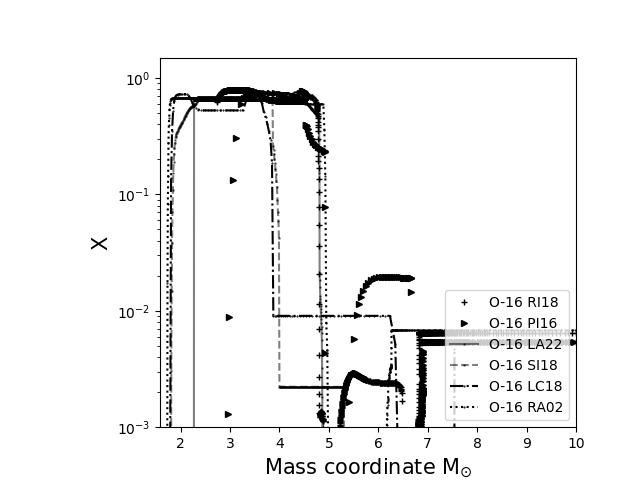

In [115]:
# abundance plot for selected isotopes; all together
ifig=24; plt.figure(ifig)

iso_selected = 'O-16'
ind_ = e_label.index(iso_selected)

# to plot abundances (ritter2018)

# index to skip what is not ejected
ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
#
plt.semilogy(mass[ind_tmp:],e_abund[ind_][ind_tmp:],color=col[ind_],marker=llin,markersize=4,ls='',\
                 label=e_label[ind_]+' RI18')

# Pignatari+16
# index to skip what is not ejected
p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
#
plt.semilogy(p16_mass[p16_ind_tmp:],p16_abund[ind_][p16_ind_tmp:],color=col[ind_],marker='>',markersize=4,ls='',\
                 label=e_label[ind_]+' PI16')


# to plot abundances (Lawson+2022)
plt.semilogy(mass_inc,y[ind_],color=col[ind_],marker=lin,ls='-',markersize=0.8,alpha=0.5,\
            label=e_label[ind_]+' LA22')

    
# to plot Sieverdin data    
plt.semilogy(mass_sie[:],sie_abund[ind_],color=col[ind_],marker=lllin,ls='--',markersize=0.8,alpha=0.5,
            label=e_label[ind_]+' SI18')


# to plot abundances (Limongi & Chieffi 2018)
plt.semilogy(lc18_mass_1,lc18_y[ind_],color=col[ind_],marker=lin,ls='-.',markersize=0.5,alpha=1,
            label=e_label[ind_]+' LC18')
    

# to plot abundances (Rauscher+2002)
plt.semilogy(rau_mass_1,rau_y[ind_],color=col[ind_],marker=lin,ls=':',markersize=0.5,alpha=1,
            label=e_label[ind_]+' RA02')



plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10); plt.ylim(1e-3,1.5)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('test'+iso_selected+'.pdf')
plt.show()


In [116]:
#p16_t9_cyc

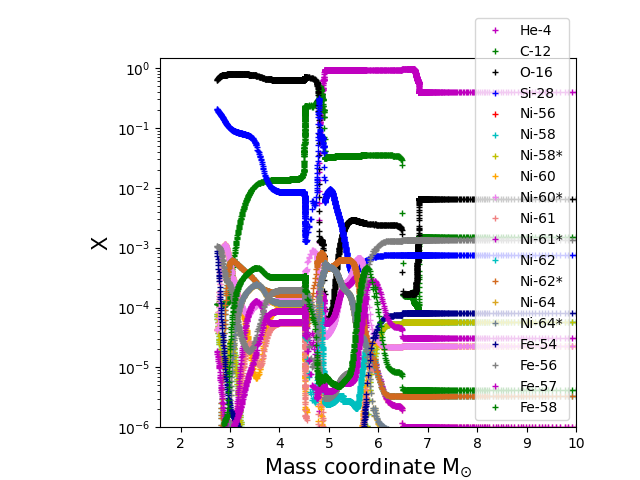

In [117]:
# abundance plot; Ritter
ifig=11; plt.figure(ifig)



# to plot abundances (ritter2018)

# index to skip what is not ejected
ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
#
for i in range(len(iso_list)):
    plt.semilogy(mass[ind_tmp:],e_abund[i][ind_tmp:],color=col[i],marker=llin,\
                 markersize=4,ls='',label=e_label[i])


   


plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
plt.gcf().subplots_adjust(left=0.25)    

#plt.savefig('another_test.pdf')
plt.show()

In [118]:
## abundance plot; Lawson
#ifig=12; plt.figure(ifig)
#
#
#
#
## to plot abundances (Lawson+2022)
#for i in range(len(iso_list)):
#    plt.semilogy(mass_inc,y[i],color=col[i],marker=lin,ls='-',markersize=0.8,alpha=0.5,\
#                label=e_label[i])
#
#    
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('test.pdf')
#plt.show()

In [119]:
## abundance plot; Sieverdin
#ifig=13; plt.figure(ifig)
#
#
#    
## to plot Sieverdin data    
#for i in range(len(iso_list)):
#    plt.semilogy(mass_sie[:],sie_abund[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
#                 alpha=0.95,label=e_label[i])
#   
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-8,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
#plt.show()

In [120]:
## abundance plot; LC18
#ifig=17; plt.figure(ifig)
#
#
#    
## to plot Sieverdin data    
#for i in range(len(iso_list)):
#    plt.semilogy(lc18_mass_1,lc18_y[i],color=col[i],marker=lllin,ls='-',markersize=0.8,\
#                 alpha=0.95,label=e_label[i])
#
#    
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-8,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
#plt.show()

In [121]:
## abundance plot; P16
#ifig=18; plt.figure(ifig)
#
#
#
## to plot abundances (Pignatari+16)
#
## index to skip what is not ejected
#p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
##
#for i in range(len(iso_list)):
#    plt.semilogy(p16_mass[p16_ind_tmp:],p16_abund[i][p16_ind_tmp:],color=col[i],marker='>',\
#                 markersize=4,ls='-',label=e_label[i])
#
#
#   
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:])) 
#masscut = min(masscut,p16_mass[p16_ind_tmp])
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('another_test.pdf')
#plt.show()

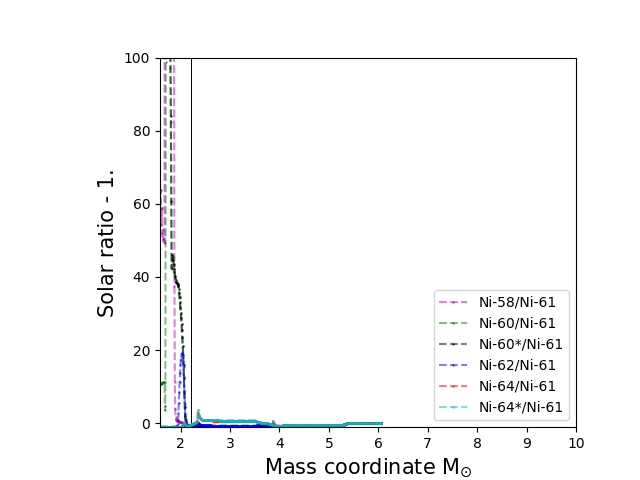

In [122]:
# ratio plot; Sieverdin
ifig=131; plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot Sieverdin data    
for i in range(len(iso_up_plot)):
    plt.plot(mass_sie[:],sie_deltapmil[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
    
    

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-1.1,100)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel2,fontsize=15)
plt.gcf().subplots_adjust(left=0.25)    

plt.show()

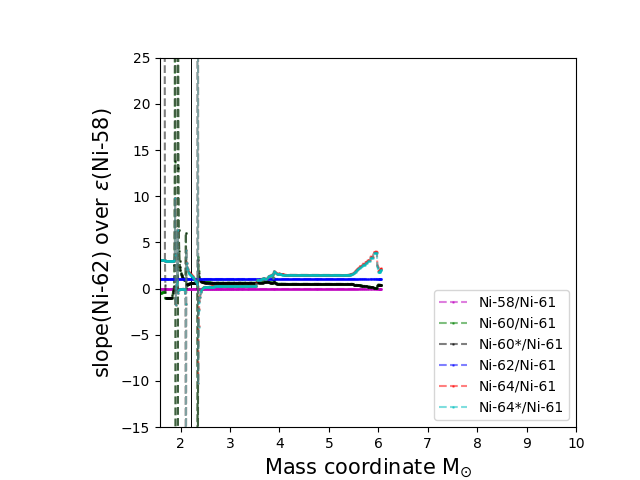

In [123]:
# ratio plot; Sieverdin
ifig=136; plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot Sieverdin data    
for i in range(len(iso_up_plot)):
    plt.plot(mass_sie[:],sie_slope[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
    
    

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-15,25)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.gcf().subplots_adjust(left=0.25)    

plt.show()

In [124]:
## abundance plot; Sieverdin
#ifig=78; plt.figure(ifig)
#
#
#    
## to plot Rauscher data    
#for i in range(len(iso_list)):
#    plt.semilogy(rau_mass_1,rau_y[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
#                 alpha=0.95,label=e_label[i])
#   
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-8,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
#plt.show()

In [125]:
new_list = ['Ni-58','Ni-61', 'Ni-62', 'Ni-64','Ni-64*']
ind_mass = np.where(np.array(rau_mass_1)>4.2)[0][0]
ind_iso = [e_label.index(i) for i in new_list]
print('mass=',str('%.2e' % rau_mass_1[ind_mass]),'Msun')
print(new_list)
print([rau_y[i][ind_mass] for i in ind_iso])

mass= 4.20e+00 Msun
['Ni-58', 'Ni-61', 'Ni-62', 'Ni-64', 'Ni-64*']
[1.04702e-05, 0.000127108, 0.000318285, 5.66759e-05, 5.903632e-05]


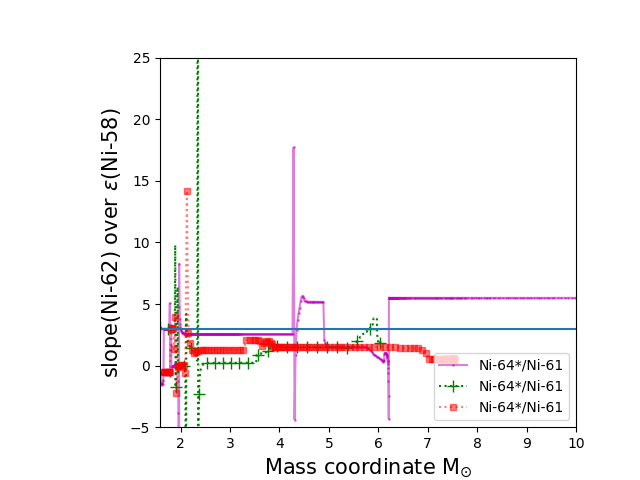

In [126]:
# ratio plot; Rauscher
ifig=87; plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = rau_mass_1[np.argmax(rau_y[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot stellar data    
#for i in range(len(iso_up_plot)):
#for i in [1,4]:
#for i in [4]:
#    plt.plot(rau_mass_1,rau_slope[i],color=col[0],marker=lllin,ls='-',markersize=0.8,\
#                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass_sie[:],sie_slope[i],color=col[1],marker='+',ls=':',markersize=8,\
#                 alpha=1,markevery=20,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass_inc,law_slope[i],color=col[2],marker='x',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass[ind_tmp:],rit_slope[i][ind_tmp:],color=col[3],marker='*',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
i = iso_up_plot.index('Ni-64*')
plt.plot(rau_mass_1,rau_slope[i],color=col[0],marker=lllin,ls='-',markersize=0.8,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass_sie[:],sie_slope[i],color=col[1],marker='+',ls=':',markersize=8,\
         alpha=1,markevery=20,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#plt.plot(mass_inc,law_slope[i],color=col[2],marker='x',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#plt.plot(mass[ind_tmp:],rit_slope[i][ind_tmp:],color=col[3],marker='*',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(lc18_mass_1,lc18_slope[i],color=col[4],marker=lllin,ls=':',markersize=4,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#plt.plot(p16_mass[p16_ind_tmp:],p16_slope[i][p16_ind_tmp:],color=col[5],marker='>',ls=':',markersize=4,\
#                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])

    
plt.axhline(y=3)    

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-5,25)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('tmp.pdf')

plt.show()

In [127]:
#print(len(mass[ind_tmp:]),len(rit_slope[0][ind_tmp:]))

In [128]:
#print(law_slope[4][0:1000])

In [130]:
## ratio plot; slopes
#plt.figure().clear()
#ifig=75; plt.figure(ifig)
#
#iso_plot = 'Ni-64'; iso_ref = 'Ni-61'
#ind_ = iso_up_plot.index(iso_plot)
#indu_ = e_label.index(iso_plot); indd_ = e_label.index(iso_ref) 
#indn_ = e_label.index(iso_norm_mu_and_eps) ; inds_ = e_label.index(iso_norm_slope) 
#
#ind_c12 = e_label.index("C-12"); ind_o16 = e_label.index("O-16")
#
#lim_relevance = 1e0
#
##what_slope = rau_slope; what_abu = rau_y; surf_ind = -1
##what_slope = sie_slope; what_abu = sie_abund; surf_ind = -1 
##what_slope = rit_slope; what_abu = e_abund; surf_ind = -1
#what_slope = law_slope; what_abu = y; surf_ind = -1  
##what_slope = lc18_slope; what_abu = lc18_y; surf_ind = -1  
##what_slope = p16_slope; what_abu = p16_abund; surf_ind = -1
#
#[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='c')  for i in range(len(what_slope[ind_])) if\
#    what_abu[ind_][i] > lim_relevance * what_abu[ind_][surf_ind] or \
#    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
#    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
#    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
#    if what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
#[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='r')  for i in range(len(what_slope[ind_])) if\
#    what_abu[ind_][i] > lim_relevance *  what_abu[ind_][surf_ind] or \
#    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
#    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
#    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
#    if what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]
#
## add comparison - AGB - crazy here since I have only one final snapshot
## note that here below I cannot use surface abundances as indicative anymore....
## well, this is not safe to do either for CCSNe with WR progenitors, Novae, etc. So, all of this will need to
## changed, and use solar as reference or solar scaled.
#what_slope = np.transpose(np.concatenate(([bat_slope], [bat_slope]), axis=0))
#what_abu = np.transpose(np.concatenate(([agb_abund], [agb_abund]), axis=0)) 
#surf_ind = -1        
#
#[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
#    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
#[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
#    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]
#[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='c',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
#    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
#[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='r',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
#    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]
#
#plt.axhline(y=0,color='k'); plt.axvline(x=0,color='k')
#
## slope from obs?
#sl = 3.0
#plt.axline((0, 0.0), slope=sl, color="black", linestyle=(0, (5, 5)), lw=3)
#plt.text(0.1, 0.5, "slope="+str(sl), rotation=70, fontsize=12)
#
#plt.title('slope('+iso_plot+\
#          ') LA22 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')
##plt.title('slope('+iso_plot+\
##          ') SI18 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')
#
#plt.xlim(-1,1); plt.ylim(-1,1)
#
#plt.savefig('la22_vs_bat20'+iso_plot+'slope.pdf')
#
#plt.show()
#